In [1]:
import pandas as pd
import openml
from openml.datasets import edit_dataset, fork_dataset, get_dataset

data_name = 'ada'

data = openml.datasets.get_dataset(41156)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

In [2]:
nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
dummied_data = pd.get_dummies(X, columns=nominal)

columns = dummied_data.columns
updates = {}
for col in columns:
    if any(x in col for x in set(('[', ']', '=', '>', '<', ' ', '/', '(', ')', '-', '?'))):
        updates[col] = col.replace('?', '_').replace('-', '_').replace(')', '_').replace('(', '_').replace(' ', '_').replace(',', '_').replace('[', '_').replace(']', '_').replace('<', 'less').replace('>', 'greater').replace('=', 'equal').replace('/', '_')
dummied_data = dummied_data.rename(columns=updates)

dummied_data.fillna(0, inplace=True)
dummied_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48
0,0,1,1,32.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
1,0,0,1,133.0,0,0,1,0,0,0.0,...,0,242.0,0,0,0,0,0,0,0,0
2,0,0,0,109.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
3,0,0,0,113.0,0,0,0,1,0,0.0,...,0,404.0,0,0,0,1,0,1,0,0
4,0,0,0,120.0,0,0,0,1,0,0.0,...,0,303.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,0,0,0,50.0,1,0,0,1,1,0.0,...,0,404.0,0,0,0,0,0,0,0,1
4143,0,0,0,144.0,0,0,0,1,1,0.0,...,0,404.0,1,0,0,0,0,0,0,0
4144,0,0,0,129.0,0,0,0,0,0,0.0,...,0,353.0,1,1,0,0,0,0,0,0
4145,0,0,0,225.0,0,0,1,1,0,0.0,...,0,303.0,0,0,0,0,0,0,0,0


In [3]:
y

0       0
1       0
2       0
3       1
4       0
       ..
4142    0
4143    0
4144    0
4145    0
4146    1
Name: class, Length: 4147, dtype: category
Categories (2, object): ['0' < '1']

In [4]:
mapping = {'1': 1, '0': 0}

pos_label = '1'
neg_label = '0'

y = y.replace(mapping)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, left_out, y_train, y_left_out = train_test_split(dummied_data, y, test_size=0.4, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

train shape: (2488, 48)
 test shape: (829, 48)
 dev shape: (830, 48)


In [6]:
drop_list = [col for col in X_train.columns if sum(X_train[col]) <= 0]

X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
X_dev.drop(drop_list, axis=1, inplace=True)
print(f'{len(drop_list)} columns dropped')
print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

2 columns dropped
train shape: (2488, 46)
 test shape: (829, 46)
 dev shape: (830, 46)


[15:51:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.8528347406513872
recall: 0.78938225505317
precision: 0.7958226839711886
f_score: 0.7925084934924256



/home/amak2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


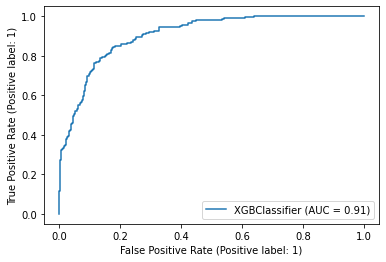

In [7]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from helper_func import plot_roc

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, 
                             learning_rate=0.1, max_depth=7000, n_estimators= 250, reg_lambda=1)

xgb_clf = xg_boost.fit(X_train, y_train)
test_ac = xgb_clf.score(X_test, y_test)
pred = xgb_clf.predict(X_test)
f_score = f1_score(y_test, pred, average='macro')
prec = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
plot_roc(xgb_clf, X_test, y_test)

[16:03:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.8528347406513872
recall: 0.78938225505317
precision: 0.7958226839711886
f_score: 0.7925084934924256



/home/amak2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


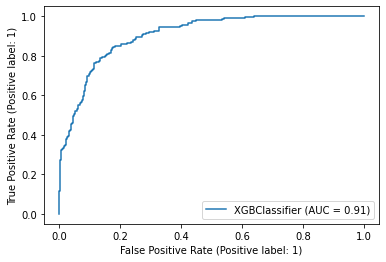

train shape: (2488, 41)
 test shape: (829, 41)
 dev shape: (830, 41)


In [8]:
names = list(X_train.columns)
values = list(xgb_clf.feature_importances_)

assert len(names) == len(values)

important_features = [p[0] for p in zip(names, values) if p[1] > 0]

to_drop = []
for cl in names:
    if cl not in important_features:
        to_drop.append(cl)

    
X_train.drop(to_drop, axis=1, inplace=True)

X_test.drop(to_drop, axis=1, inplace=True)
X_dev.drop(to_drop, axis=1, inplace=True)

xgb_clf = xg_boost.fit(X_train, y_train)

test_ac = xgb_clf.score(X_test, y_test)
pred = xgb_clf.predict(X_test)
f_score = f1_score(y_test, pred, average='macro')
prec = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
plot_roc(xgb_clf, X_test, y_test)

print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

In [9]:
from anchor import anchor_tabular
from tqdm import tqdm

pred = xgb_clf.predict(X_dev)

anch_explainer = anchor_tabular.AnchorTabularExplainer(
    [neg_label, pos_label],
    list(X_dev.columns),
    X_dev.values)

seen_rules = set()
rules = []
for i in tqdm(range(len(pred))):
    exp = anch_explainer.explain_instance(X_dev.values[i], xgb_clf.predict, threshold=0.9, beam_size=3)
    
    premise = []
    for name in exp.names():
        if len(name) < 2:
            continue
        if name.count(' ') <= 2:
            feature_name, operator, value = name.split(' ')
            premise.append({'att': feature_name, 'op': operator, 'thr': value})  
        else:
            val1, opr1, feature_name, opr2, val2 = name.split(' ')
            premise.append({'att': feature_name, 'op': (opr1, opr2), 'thr': (val1, val2)})  
    
    formatted_rule = {}
    formatted_rule['premise'] = premise
    formatted_rule['cons'] = pred[i]
    rules.append(formatted_rule)

infos = {
    "class_values":list(y_dev.unique()),
    'feature_names': list(X_dev.columns)}

100%|██████████| 830/830 [18:13<00:00,  1.32s/it]


In [10]:
import json
from numpyencoder import NumpyEncoder

with open(f'./anchors_rules/{data_name}_anchors_rules.json', 'w') as f:
    json.dump(rules, f, cls=NumpyEncoder)

with open(f'./anchors_rules/{data_name}_anchors_info.json', 'w') as b:
    json.dump(infos, b, cls=NumpyEncoder) 

In [11]:
import json
from numpy import inf
from tqdm import tqdm

def load_rules(json_file, current_feature_names):

    with open(json_file, 'r') as rules_log:
        rules = json.load(rules_log)

    rules = [r for r in rules if len(r) > 0]
    output_rules = []
    conditions = set()
    
    for rule in tqdm(rules):
        consequence = rule['cons']
        premises = rule['premise']
        features = [premise['att'] for premise in premises]
        ops = [premise['op'] for premise in premises]
        values = [premise['thr'] for premise in premises]
        values_per_feature = {feature: [val for f, val in zip(features, values) if f == feature]
                              for feature in features}
        ops_per_feature = {feature: [op for f, op in zip(features, ops) if f == feature]
                           for feature in features}

        local_rule = set()
        for f in features:
            
            assert f in current_feature_names
            
            values, operators = values_per_feature[f], ops_per_feature[f]
            if type(values[0]) == list:
                values = values[0]
                operators = operators[0]
            # 1 value, either <= or >
            if len(values) == 1:
                condition = f'{f} {operators[0]} {values[0]}'
            # 2 values, < x <=
            else:
                condition = f'{values[0]} {operators[0]} {f} {operators[1]} {values[1]}'

            conditions.add(condition)
            local_rule.add(condition)

        if consequence > 0:
            conditions.add(pos_label)
            local_rule.add(pos_label)
        else:
            conditions.add(neg_label)
            local_rule.add(neg_label)
        output_rules.append(local_rule)
    
    return (output_rules, conditions)

anchors_rules, conditions = load_rules(f'./anchors_rules/{data_name}_anchors_rules.json', 
                                    list(X_train.columns))

100%|██████████| 830/830 [00:00<00:00, 123972.52it/s]


In [12]:
from mlxtend.frequent_patterns import apriori, association_rules
import math

encoded_vals = []

for local_rule in tqdm(anchors_rules):
    
    labels = {}
    
    difference = list(conditions - local_rule)
    intersection = list(conditions.intersection(local_rule))

    for itm in difference:
        labels[itm] = 0
    for itm in intersection:
        labels[itm] = 1
    encoded_vals.append(labels)

ohe_df = pd.DataFrame(encoded_vals)



100%|██████████| 830/830 [00:00<00:00, 103090.77it/s]


In [13]:
freq_items = apriori(ohe_df, min_support=(4/len(X_dev)), use_colnames=True, max_len=3)
all_rules = association_rules(freq_items, metric="confidence", min_threshold=0.5, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[pos_label] == 1], min_support=(4/len(X_dev)), use_colnames=True, max_len=3)
pos_rules = association_rules(freq_items, metric="confidence", min_threshold=0.25, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[neg_label] == 1], min_support=(4/len(X_dev)), use_colnames=True, max_len=3)
neg_rules = association_rules(freq_items, metric="confidence", min_threshold=0.25, support_only=False)

In [14]:
positive = all_rules[all_rules['consequents'] == {pos_label}]
positive = positive[positive['confidence'] == 1]
positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

positive = positive.reset_index(drop=True)
print(len(positive))
for i in positive.index:
    new_rule = positive.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

positive.drop(positive.index[indexes_to_drop], inplace=True )
print(len(positive))

887
54


In [15]:
negative = all_rules[all_rules['consequents'] == {neg_label}]
negative = negative[negative['confidence'] == 1]

negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

negative = negative.reset_index(drop=True)
print(len(negative))
for i in negative.index:
    new_rule = negative.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

negative.drop(negative.index[indexes_to_drop], inplace=True )
print(len(negative))

34
16


In [16]:
positive['num-items'] = positive['antecedents'].map(lambda x: len(x))
negative['num-items'] = negative['antecedents'].map(lambda x: len(x))
positive['consequents'] = positive['consequents'].map(lambda x: pos_label)
negative['consequents'] = negative['consequents'].map(lambda x: neg_label)

both = positive.append(negative, ignore_index=True)

discr_rules = both[['antecedents', 'consequents', 'num-items', 'support', 'confidence', 'antecedent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

discr_rules = discr_rules.rename(columns={"antecedents": "itemset", "consequents": "label"})

discr_rules

,itemset,label,num-items,support,confidence,antecedent support
54,(V44 <= 0.00),0,1,0.528916,1.0,0.528916
0,(V44 > 0.00),1,1,0.178313,1.0,0.178313
55,(V15 <= 562.00),0,1,0.122892,1.0,0.122892
1,(V31 > 0.00),1,1,0.113253,1.0,0.113253
2,(V15 > 624.00),1,1,0.090361,1.0,0.090361
...,...,...,...,...,...,...
49,(V36 > 0.00),1,1,0.004819,1.0,0.004819
50,(V11 <= 0.00),1,1,0.004819,1.0,0.004819
51,(V31 <= 1.00),1,1,0.004819,1.0,0.004819
52,(0.00 < V19 <= 1.00),1,1,0.004819,1.0,0.004819


In [17]:
rev_positive = pos_rules[pos_rules['antecedents'] == {pos_label}]
#rev_positive = rev_positive[rev_positive['confidence'] >= 0.8]
rev_positive = rev_positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_positive = rev_positive.reset_index(drop=True)
print(len(rev_positive))
for i in rev_positive.index:
    new_rule = rev_positive.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_positive.drop(rev_positive.index[indexes_to_drop], inplace=True )
print(len(rev_positive))



rev_negative = neg_rules[neg_rules['antecedents'] == {neg_label}]
#rev_negative = rev_negative[rev_negative['confidence'] >= 0.8]
rev_negative = rev_negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_negative = rev_negative.reset_index(drop=True)
print(len(rev_negative))
for i in rev_negative.index:
    new_rule = rev_negative.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_negative.drop(rev_negative.index[indexes_to_drop], inplace=True )
print(len(rev_negative))

11
8
1
1


In [19]:
rev_positive['num-items'] = rev_positive['consequents'].map(lambda x: len(x))
rev_negative['num-items'] = rev_negative['consequents'].map(lambda x: len(x))
rev_positive['antecedents'] = rev_positive['antecedents'].map(lambda x: pos_label)
rev_negative['antecedents'] = rev_negative['antecedents'].map(lambda x: neg_label)

rev_both = rev_positive.append(rev_negative, ignore_index=True)

chr_rules = rev_both[['antecedents', 'consequents', 'num-items', 'support', 
                          'confidence', 'consequent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

chr_rules = chr_rules.rename(columns={"antecedents": "label", "consequents": "itemset"})

chr_rules

,label,itemset,num-items,support,confidence,consequent support
0,1,(V44 > 0.00),1,0.791444,0.791444,0.791444
8,0,(V44 <= 0.00),1,0.682737,0.682737,0.682737
1,1,(V31 > 0.00),1,0.502674,0.502674,0.502674
2,1,(V15 > 624.00),1,0.401070,0.401070,0.401070
3,1,(V40 > 454.00),1,0.342246,0.342246,0.342246
4,1,(V42 <= 0.00),1,0.326203,0.326203,0.326203
5,1,(V13 <= 0.00),1,0.315508,0.315508,0.315508
6,1,(V45 <= 0.00),1,0.299465,0.299465,0.299465
7,1,(V27 <= 0.00),1,0.283422,0.283422,0.283422


In [28]:
ohe_df

,V31 <= 0.00,624.00 < V15 <= 812.00,V30 <= 0.00,311.00 < V25 <= 411.00,V4 > 78.00,V41 <= 1.00,V15 > 812.00,V10 > 0.00,V12 > 0.00,0,...,V5 <= 0.00,V25 > 311.00,V7 <= 0.00,V41 <= 0.00,V12 <= 0.00,V36 <= 0.00,1,V13 <= 0.00,V42 <= 0.00,V44 > 0.00
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
826,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
827,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
828,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


100%|██████████| 830/830 [00:28<00:00, 29.30it/s]
Acc: 0.8698795180722891
macro rules recall: 0.8250014554103842
macro rules prec: 0.8112113658625935
macro rules f1_score: 0.8177174416996771
187 199


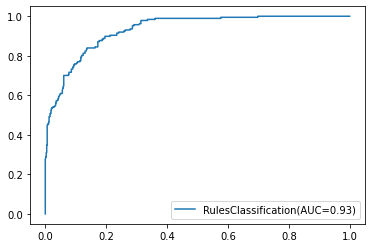

coverage: 1.00
70 rules generated


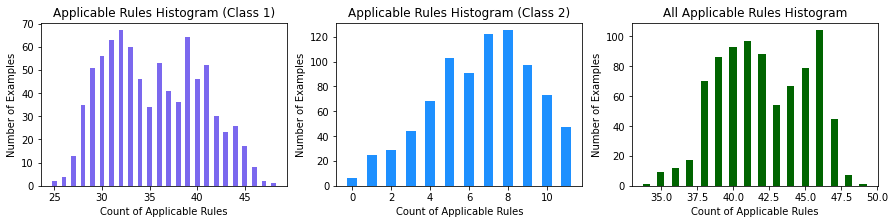

In [34]:
from anchors_rules_model import *

dev_pred = xgb_clf.predict(X_dev)
rules_model = RulesModel(ohe_df, discr_rules, y_dev, pos_label, neg_label)

rules_test_sol = rules_model.predict(X_dev, dev_pred, alpha=100, beta=len(discr_rules), decision_thr=0.91)

100%|██████████| 829/829 [00:28<00:00, 28.61it/s]
Acc: 0.8673100120627262
macro rules recall: 0.8183398612540247
macro rules prec: 0.8092054357287939
macro rules f1_score: 0.8135997187336473
188 196


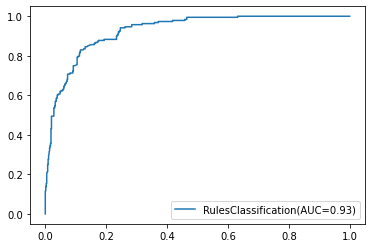

coverage: 1.00
70 rules generated


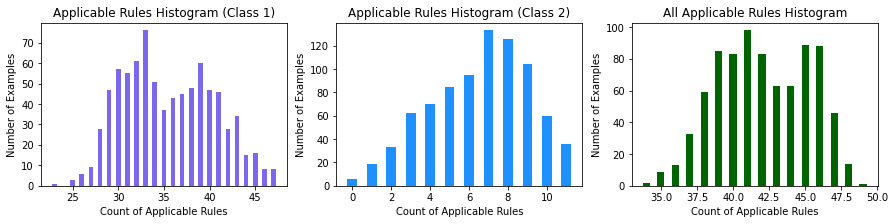

In [36]:
test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.predict(X_test, test_pred, alpha=100, beta=len(discr_rules), decision_thr=0.91)

100%|██████████| 830/830 [00:03<00:00, 210.32it/s]
Acc: 0.8734939759036144
macro rules recall: 0.7875142422301877
macro rules prec: 0.8320813801583032
macro rules f1_score: 0.8062381747480429
187 154


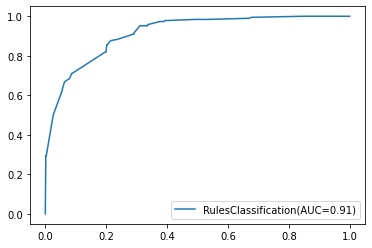

coverage: 1.00
9 rules generated


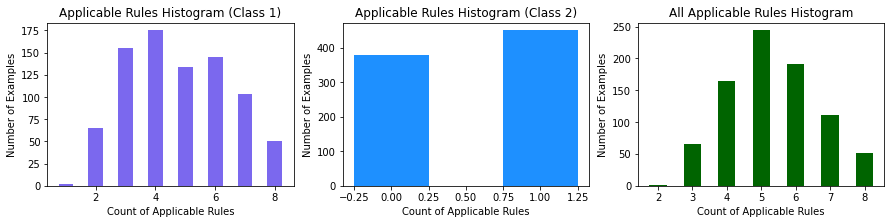

In [49]:
rules_model = RulesModel(ohe_df, chr_rules, y_dev, pos_label, neg_label)

dev_pred = xgb_clf.predict(X_dev)
rules_dev_sol = rules_model.predict(X_dev, dev_pred, alpha=100, beta=10, decision_thr=0.876)

100%|██████████| 829/829 [00:04<00:00, 202.04it/s]
Acc: 0.8697225572979493
macro rules recall: 0.7823090583197796
macro rules prec: 0.8272775372775373
macro rules f1_score: 0.8010718285074387
188 154


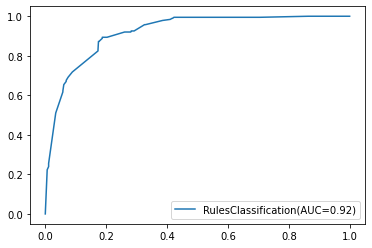

coverage: 1.00
9 rules generated


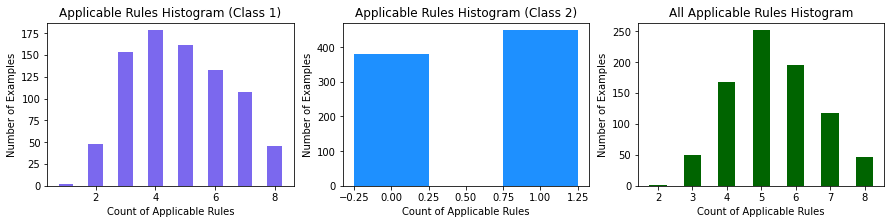

In [50]:

test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.predict(X_test, test_pred, alpha=100, beta=10, decision_thr=0.876)